In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import tarfile
import matplotlib.pyplot as plt

In [ ]:
def display(chips, i=0):
    rgb = chips[i, [3, 2, 1], :, :]
    rgb = rgb.transpose(1, 2, 0)
    rgb = np.clip(rgb, 0, 2500)
    rgb = (rgb / 2500) * 0xff
    rgb = rgb.astype(np.uint8)

    plt.imshow(rgb)

In [ ]:
def display_all(chips):
    grid_size = int(np.ceil(np.sqrt(chips.shape[0])))
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i in range(grid_size * grid_size):
        if i < chips.shape[0]:
            rgb = chips[i, [3, 2, 1], :, :]
            rgb = rgb.transpose(1, 2, 0)
            rgb = np.clip(rgb, 0, 2500)
            rgb = (rgb / 2500) * 0xff
            rgb = rgb.astype(np.uint8)
            ax[i // grid_size, i % grid_size].imshow(rgb)
            ax[i // grid_size, i % grid_size].axis('off')
        else:
            # Hide empty subplots
            ax[i // grid_size, i % grid_size].axis('off')

    plt.show()

# Attention #

## Load and patch models ##

In [2]:
device = torch.device("cuda")

In [3]:
def new_forward(self, x):
    (series, channels, height, width) = x.shape
    batch = 1
    shape = [-1, channels, height, width]
    x = x.reshape(*shape)  # (batch * series, channels, height, width)
    x = self.net(x).squeeze()  # (batch * series, E)

    attn_weights = self.classifier(x)  # (batch * series, D1)
    attn_weights = self.attn_linear1(attn_weights)  # (batch * series, D2)
    attn_weights = F.relu(attn_weights)
    attn_weights = self.attn_linear2(attn_weights)  # (batch * series, 1)
    shape = [batch, series, 1]
    attn_weights = attn_weights.reshape(*shape)  # (batch, series, 1)
    attn_weights = F.softmax(attn_weights, dim=1)

    shape = list(x.shape)
    shape = [batch, series] + shape[1:]
    x = x.reshape(*shape)  # (batch, series, E)
    x = x * attn_weights
    x = torch.sum(x, dim=1)  # (batch, E)
    return x, attn_weights

In [4]:
import types

In [5]:
models = {}
for arch in ["mobilenetv3", "resnet18", "resnet34", "resnet50"]:
    with tarfile.open(f"/datasets/geospatial-time-series/{arch}.tar.gz", "r:gz") as tar:
        model = torch.load(tar.extractfile("model.pth"), map_location=device).to(device)
    model.forward = types.MethodType(new_forward, model)
    model.eval()
    models.update({arch: model})

## Subroutine to display ##

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_all_attn(chips, border_colors):
    # Normalize the border_colors array
    min_color = np.min(border_colors)
    max_color = np.max(border_colors)
    border_colors = (border_colors - min_color) / (max_color - min_color)
    
    grid_size = int(np.ceil(np.sqrt(chips.shape[0])))
    fig, ax = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    for i in range(grid_size * grid_size):
        if i < chips.shape[0]:
            rgb = chips[i, [3, 2, 1], :, :]
            rgb = rgb.transpose(1, 2, 0)
            rgb = np.clip(rgb, 0, 2500)
            rgb = (rgb / 2500) * 0xff
            rgb = rgb.astype(np.uint8)
            
            ax[i // grid_size, i % grid_size].imshow(rgb)
            
            # Add colored border based on the normalized border_colors array
            border_color = (border_colors[i], 0, 1-border_colors[i]) # (Red, Green, Blue)
            rect = patches.Rectangle((0,0), rgb.shape[1], rgb.shape[0], linewidth=13, edgecolor=border_color, facecolor='none')
            ax[i // grid_size, i % grid_size].add_patch(rect)
            
            ax[i // grid_size, i % grid_size].axis('off')
        else:
            # Hide empty subplots
            ax[i // grid_size, i % grid_size].axis('off')

    plt.show()

## Perform inference and display ##

In [7]:
chips = np.load("/datasets/foss4g-data/orchard/38NMG/1223333130323/chip/ef04cd384ecc47a2b724fe5ebe56843e.chip.npz").get("chips")

In [8]:
with torch.inference_mode():
    e, w = models.get("mobilenetv3")(torch.tensor(chips.astype(np.float32), device=device))
e = e.cpu().numpy()[0, :]
w = w.cpu().numpy()[0, :, 0]

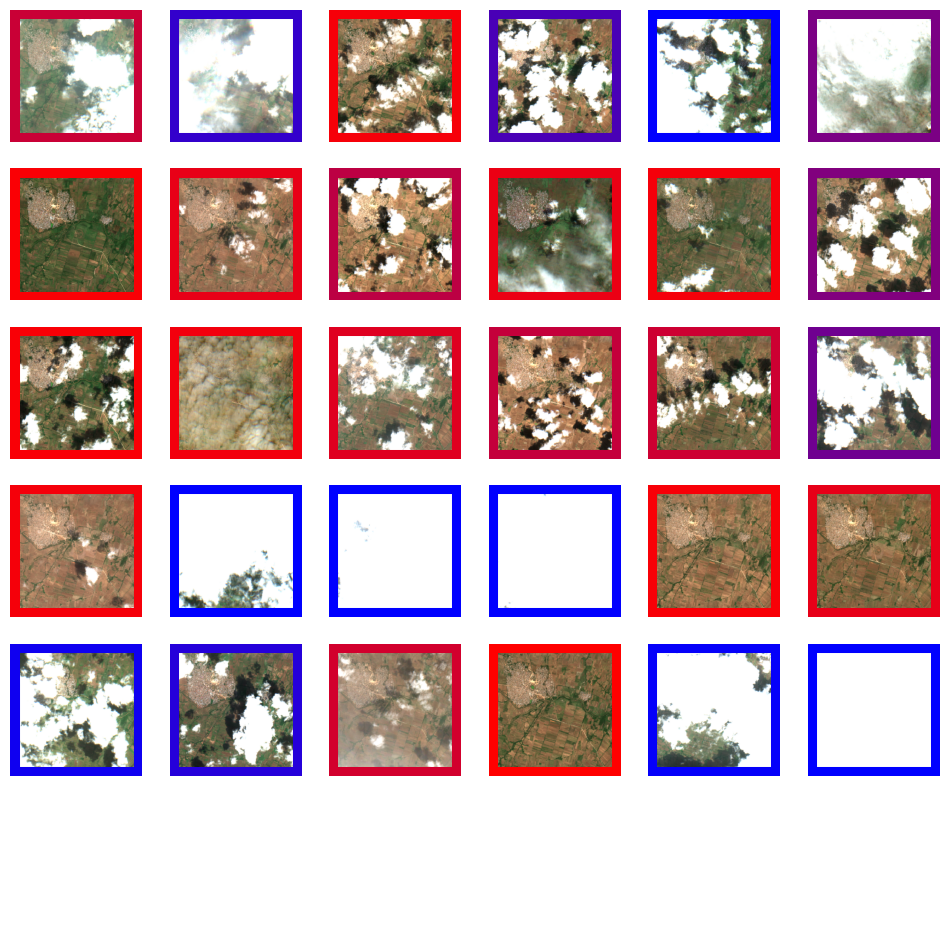

In [9]:
display_all_attn(chips, w)

In [10]:
with torch.inference_mode():
    e, w = models.get("resnet50")(torch.tensor(chips.astype(np.float32), device=device))
e = e.cpu().numpy()[0, :]
w = w.cpu().numpy()[0, :, 0]

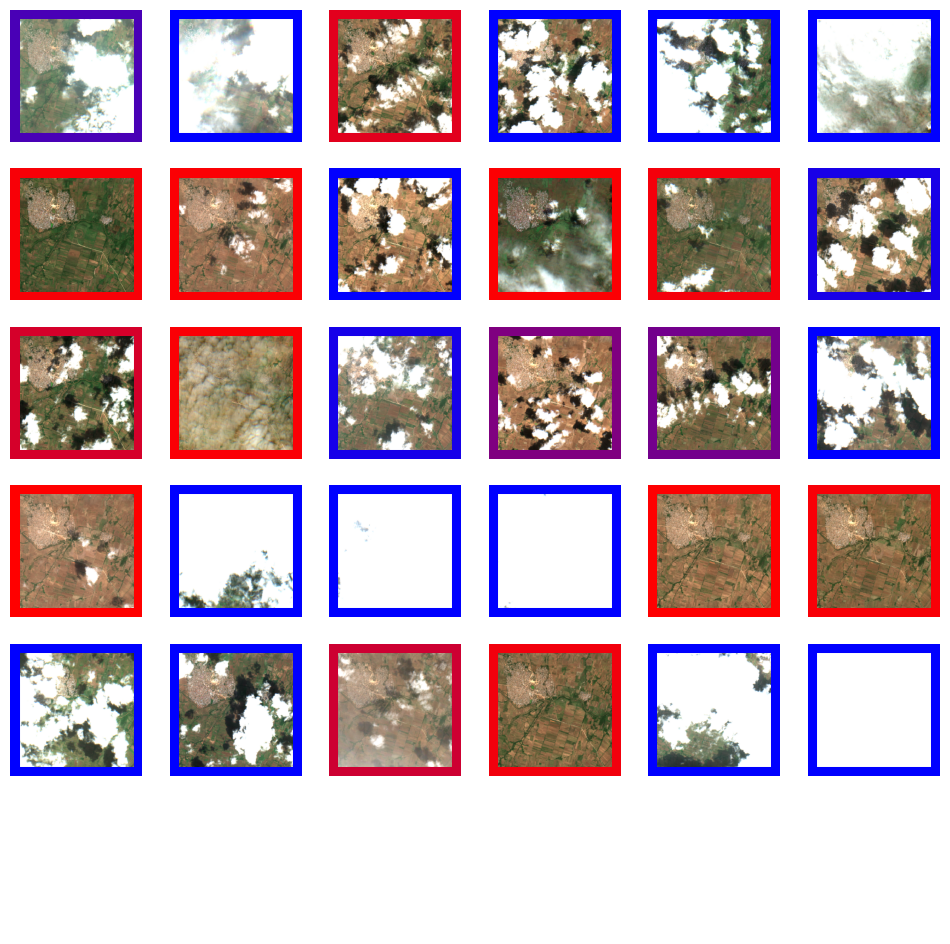

In [11]:
display_all_attn(chips, w)